In [1]:
import os
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision.transforms as standard_transforms
from skimage import io, transform
from sklearn.model_selection import train_test_split

from data_loader import TextSegDataset
import numpy as np
import glob
import os

from matplotlib import pyplot as plt
from u2net import U2NET

from PIL import Image

import time
import datetime

from PIL import ImageFile

In [2]:
images = []
masks = []

images_path = 'data/image/'
masks_path = 'data/semantic_label/'
img_size = 500

for path in glob.glob(images_path + '*'):
    # img_tensor = torch.from_numpy(io.imread(path))
    # img_resized = T.Resize((img_size, img_size))(img_tensor)
    # images.append(img_resized)
    images.append(io.imread(path))

for path in glob.glob(masks_path + '*'):
    # mask_tensor = torch.from_numpy(io.imread(path))
    # mask_resized = T.Resize((img_size, img_size))(mask_tensor)
    # masks.append(mask_resized)
    masks.append(io.imread(path))

images = np.array(images)
masks = np.array(masks)


KeyboardInterrupt: 

In [2]:
images_path = 'data/image/'
masks_path = 'data/semantic_label/'

images_path_list = glob.glob(images_path + '*')
mask_path_list = glob.glob(masks_path + '*')

original_dataset = TextSegDataset(
    images_paths=images_path_list,
    masks_path=mask_path_list,
    transform=False
)

modified_dataset = TextSegDataset(
    images_paths=images_path_list,
    masks_path=mask_path_list,
    transform=True
)

augmented_dataset = original_dataset + modified_dataset

In [7]:

epoch_num = 1000
batch_size = 10
test_batch_size = 8
train_num = len(images_path_list)
validation_split = 0.15

train_dataset_size = int(2 * train_num * (1 - validation_split))
test_dataset_size = 2 * train_num - train_dataset_size

train_dataset, test_dataset = torch.utils.data.random_split(augmented_dataset, (train_dataset_size, test_dataset_size),
                                                            generator=torch.Generator().manual_seed(721))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=1)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

net = U2NET(3, 1)
net.to(device)

model_name = f'u2net_{datetime.datetime.now().date()}'

checkpoint_name = 'u2net_2021-12-23_epoch_0_train_0.5615894327386778_test_0.4500891561835807.pth'
# checkpoint_name = False
folder_name = 'saved_models_rg/'
if checkpoint_name:
    net.load_state_dict(torch.load(folder_name + checkpoint_name, map_location=torch.device(device)))


cuda


In [9]:
def muti_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, labels_v):
    loss0 = nn.BCELoss(size_average=True)(d0, labels_v)
    loss1 = nn.BCELoss(size_average=True)(d1, labels_v)
    loss2 = nn.BCELoss(size_average=True)(d2, labels_v)
    loss3 = nn.BCELoss(size_average=True)(d3, labels_v)
    loss4 = nn.BCELoss(size_average=True)(d4, labels_v)
    loss5 = nn.BCELoss(size_average=True)(d5, labels_v)
    loss6 = nn.BCELoss(size_average=True)(d6, labels_v)

    loss = loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6

    return loss0, loss

In [10]:
#optimizer = optim.Adagrad(net.parameters(), lr=0.00001, eps=1e-08, weight_decay=1e-4)
optimizer = optim.Adam(net.parameters(), lr=0.0001, eps=1e-08, weight_decay=1e-6,amsgrad=True)
#optimizer = optim.RMSprop(net.parameters(), lr=0.00001, eps=1e-08, weight_decay=1e-6, centered=True)

for epoch in range(0, epoch_num):
    net.train()
    train_loss = 0
    test_loss = 0

    for i, train_data in enumerate(train_dataloader):
        start_time = time.time()

        train_inputs = train_data['image'].to(device)
        train_labels = train_data['mask'].to(device)

        # y zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        d0, d1, d2, d3, d4, d5, d6 = net(train_inputs)

        _, loss = muti_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, train_labels)

        loss.backward()

        optimizer.step()

        # # print statistics
        train_loss += loss.data.item()

        end_time = time.time()
        eta = (end_time - start_time) * (train_dataset_size - (i + 1) * batch_size) / batch_size
        print(
            f"epoch: {epoch + 1}/{epoch_num} eta:{int(eta)} s batch: {(i + 1)}/{int(train_dataset_size / batch_size)},"
            f" loss: {train_loss / (i + 1)} ")

    print('testing')
    with torch.no_grad():
        for j, test_data in enumerate(test_dataloader):
            test_inputs = test_data['image'].to(device)
            test_labels = test_data['mask'].to(device)

            d0, d1, d2, d3, d4, d5, d6 = net(test_inputs)
            _, loss = muti_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, test_labels)

            # # print statistics
            test_loss += loss.data.item()

    print(
        f"epoch: {epoch + 1}/{epoch_num} loss: {train_loss * batch_size / train_dataset_size} test loss: {test_loss * batch_size / test_dataset_size} ")

    torch.save(net.state_dict(),
               folder_name + model_name + f"_epoch_{epoch}_train_{train_loss * batch_size / train_dataset_size}_test_{test_loss * batch_size / test_dataset_size}.pth")
    # train_loss = 0.0
    net.train()  # resume train
#   train_step_save = 0

epoch: 1/1000 eta:1467 s batch: 1/684, loss: 0.34310340881347656 
epoch: 1/1000 eta:730 s batch: 2/684, loss: 0.7454965114593506 
epoch: 1/1000 eta:942 s batch: 3/684, loss: 0.6316529711087545 
epoch: 1/1000 eta:596 s batch: 4/684, loss: 0.680466964840889 
epoch: 1/1000 eta:594 s batch: 5/684, loss: 0.6594615697860717 
epoch: 1/1000 eta:593 s batch: 6/684, loss: 0.6642239590485891 
epoch: 1/1000 eta:591 s batch: 7/684, loss: 0.6350822619029454 
epoch: 1/1000 eta:589 s batch: 8/684, loss: 0.616937167942524 
epoch: 1/1000 eta:592 s batch: 9/684, loss: 0.612724052535163 
epoch: 1/1000 eta:610 s batch: 10/684, loss: 0.5879352867603302 
epoch: 1/1000 eta:618 s batch: 11/684, loss: 0.5903409340164878 
epoch: 1/1000 eta:594 s batch: 12/684, loss: 0.5885441849629084 
epoch: 1/1000 eta:602 s batch: 13/684, loss: 0.5672789078492385 
epoch: 1/1000 eta:593 s batch: 14/684, loss: 0.6176216346876962 
epoch: 1/1000 eta:595 s batch: 15/684, loss: 0.5978915393352509 
epoch: 1/1000 eta:595 s batch: 16/6

KeyboardInterrupt: 

In [53]:
def save_output(img, mask):
    mask = mask.squeeze()

    image=Image.fromarray(img)
    # Конвертируем диапазон (0.0, 1.0) -> (0, 255)
    mask = mask.transpose(0,1).cpu().data.numpy() * 255
    # Перегоняем в pillow
    mask = Image.fromarray(mask).convert("L")
    # Увеличиваем до размера исходного изображения
    mask = mask.resize(image.size, resample=Image.BILINEAR)
    # Оригинал перегоняем в RGBA
    image.convert('RGBA')
    # Заполняем альфа канал
    image.putalpha(mask)
    # Сохраняем
    return mask,image

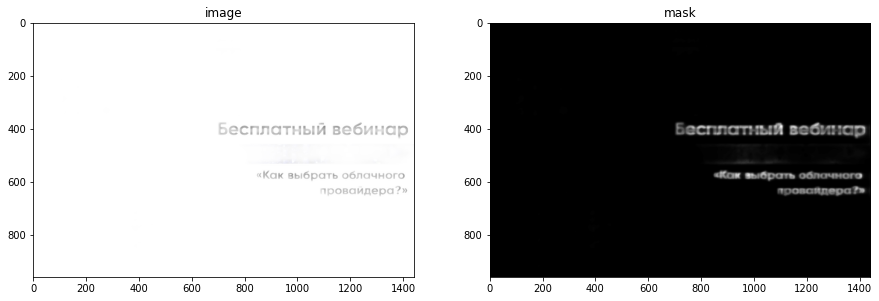

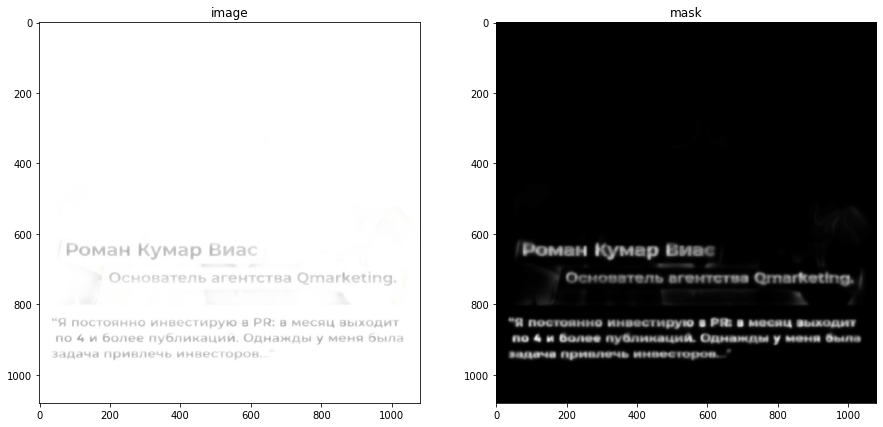

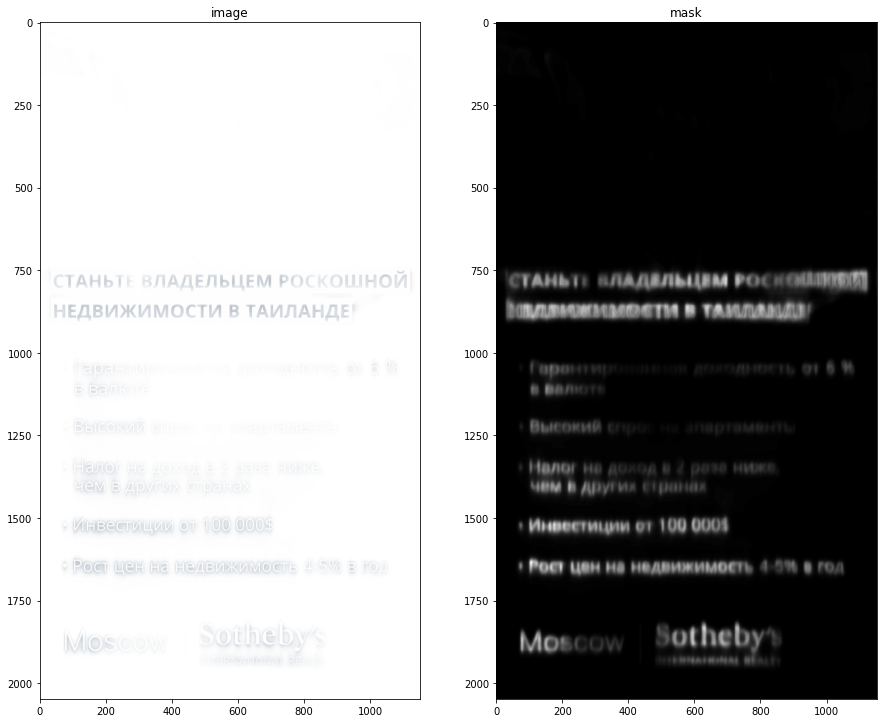

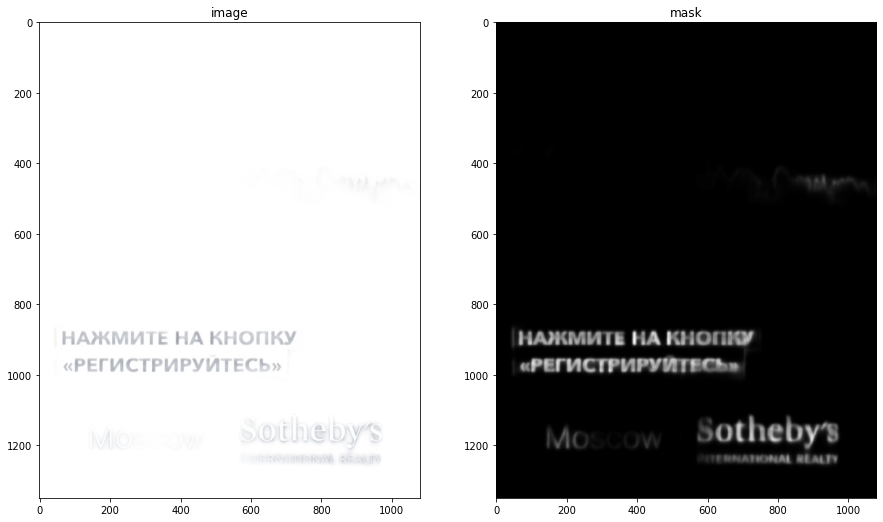

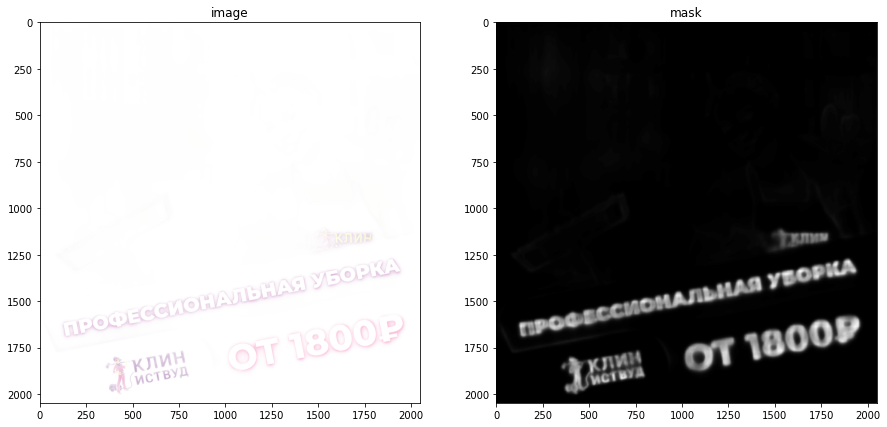

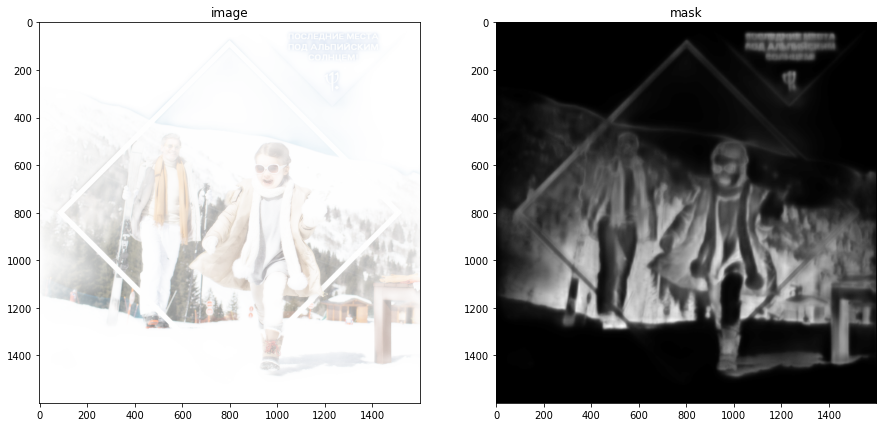

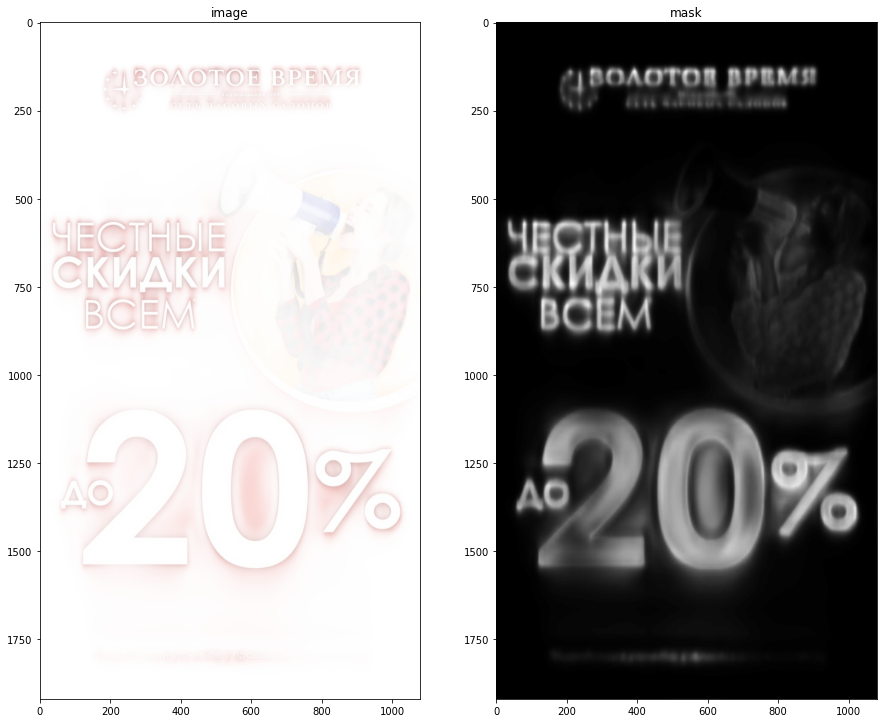

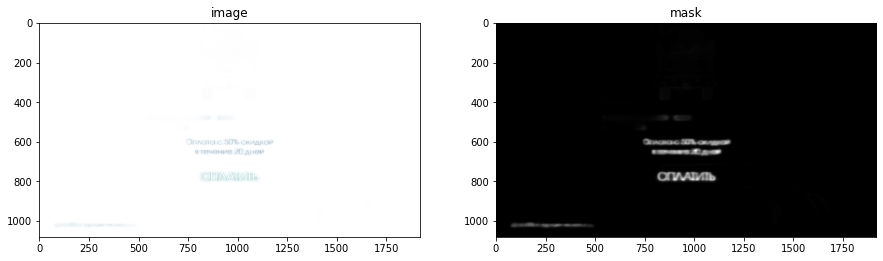

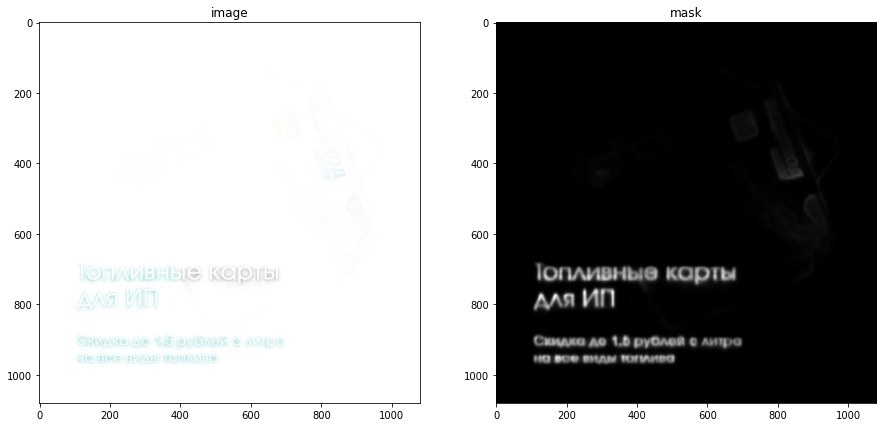

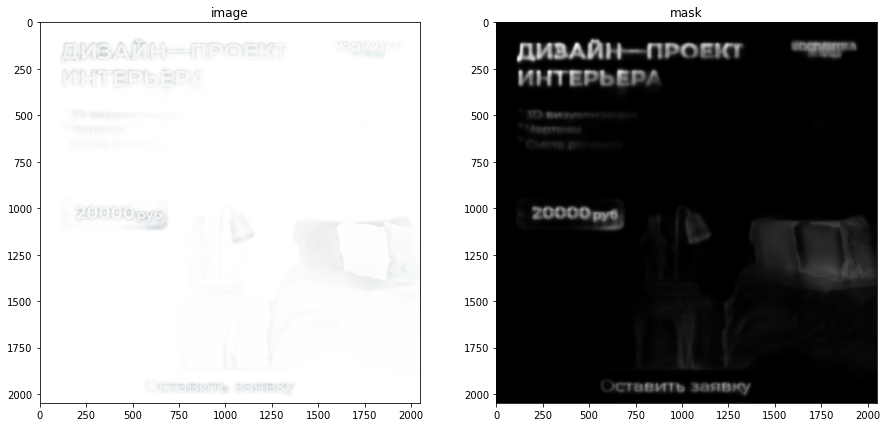

In [66]:
creatives_folder = "creatives/"
image_size=500

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = U2NET(3, 1)
net.to(device)

checkpoint_name = 'u2net_2021-12-23_epoch_0_train_0.5615894327386778_test_0.4500891561835807.pth'
# checkpoint_name = False
folder_name = 'saved_models_rg/'

net.load_state_dict(torch.load(folder_name + checkpoint_name, map_location=torch.device(device)))

net.eval()

for path in glob.glob(creatives_folder+'*'):
    img=io.imread(path)
    image_tensor = torch.from_numpy(img.astype(np.float32) / 255).transpose( 0, 2).to(device)
    image_tensor = T.Resize((image_size, image_size))(image_tensor).to(device)

    with torch.no_grad():
        d1, d2, d3, d4, d5, d6, d7 = net(image_tensor[None,:,:,:])

    # Забираем из d1 маску
    # В остальных d# тоже маски но хуже качеством
    mask = d1[:, 0, :, :]

    # сохраняем результат
    mask,image=save_output(img, mask)

    save_name=path[len(creatives_folder)+2:-3] + "result.png"

    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,15))

    ax1.imshow(image)
    ax1.set_title('image')

    ax2.imshow(mask,cmap='gray')
    ax2.set_title('mask')

    plt.show()

    del d1, d2, d3, d4, d5, d6, d7

In [27]:
glob.glob('creatives/'+'*')

['creatives\\118667__128814439_23846167627440313_5645526378078332538_n.jpg',
 'creatives\\120193__132012233_23846471394130013_886103890593103270_n.jpg',
 'creatives\\120404__106480686_23845483590350672_6768385308979807052_n.jpg',
 'creatives\\120533__116714844_23845559785760672_1187800264499353223_n.jpg',
 'creatives\\120669__117241281_23845495783890708_4829157550841142858_n.jpg',
 'creatives\\196426__86969909_23844252210430485_7729783772257714176_n.jpg',
 'creatives\\196701__121945807_23846891609120426_5540651152232821022_n.jpg',
 'creatives\\196976__121442959_23846022781670138_5407764021864252373_n.jpg',
 'creatives\\197035__120370470_23845899106150138_7435532733972545474_n.jpg',
 'creatives\\26166__118309614_23845142886070510_5389121560843978599_n.jpg']